<a href="https://colab.research.google.com/github/h5ng/uos_bigdata/blob/main/%EA%B3%BC%EC%A0%9C_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install openjdk-8-jdk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin libnss-mdns
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk openjdk-8-jdk-headless
  openjdk-8-jre openjdk-8-jre-headless x11-utils
0 upgraded, 15 newly installed, 0 to remove and 39 not upgraded.
Need to get 43.5 MB of archives.
After this 

In [2]:
!sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [3]:
!pip install language-check pycontractions

  Created wheel for language-check: filename=language_check-1.1-cp37-none-any.whl size=90190916 sha256=de0999c72405d4f434d025cb3e604e4028f2c24a74318bbdc76d8ae21a5d300a
  Stored in directory: /root/.cache/pip/wheels/d5/46/82/90a89c23eac1837364ed7217a9eed71bc9e6ad4825be93968e
Successfully built language-check


In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
from pycontractions import Contractions

np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data = pd.read_csv('./Reviews.csv', engine='python', nrows=90000)
print(len(data))

90000


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [8]:
# 중복 샘플 제거
data.drop_duplicates(subset=['Text'], inplace=True)
len(data)

80201

In [9]:
# null 샘플 제거
data.dropna(axis=0, inplace=True)
len(data)

80200

In [10]:
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

[==================================================] 100.0% 387.1/387.1MB downloaded


In [11]:
# Constraction 모듈 테스트
list(cont.expand_texts(["I'd like to know how I'd done that!",
                        "We're going to the zoo and I don't think I'll be home for dinner.",
                        "Theyre going to the zoo and she'll be home for dinner."]))

['I had like to know how I had done that!',
 'we are going to the zoo and I do not think I will be home for dinner.',
 'they are going to the zoo and she will be home for dinner.']

In [12]:
stop_words = set(stopwords.words('english'))

def preprocess_sentence(sentence, remove_stopwords=True):
  sentence = sentence.lower()
  sentence = BeautifulSoup(sentence, 'lxml').text
  sentence = re.sub(r'\([^)]*\)', '', sentence)
  sentence = re.sub('"','', sentence)
  sentence = list(cont.expand_texts([sentence]))[0]
  sentence = re.sub(r"'s\b","", sentence) 
  sentence = re.sub("[^a-zA-Z]", " ", sentence) 
  sentence = re.sub('[m]{2,}', 'mm', sentence)

  # 불용어 제거 (Text)
  if remove_stopwords:
    tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
  # 불용어 미제거 (Summary)
  else:
    tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  return tokens

In [13]:
# text열 전처리
clean_text = [preprocess_sentence(s) for s in data['Text']]
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [14]:
clean_summary = [preprocess_sentence(s, 0) for s in data['Summary']]
clean_summary[:5]

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis = 0, inplace = True)

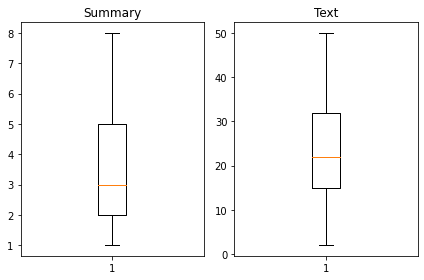

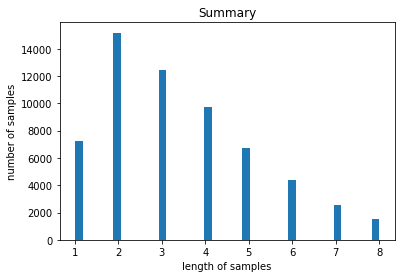

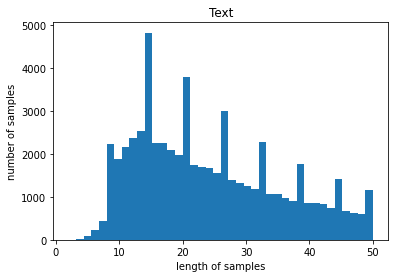

In [33]:
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
text_max_len = 50
summary_max_len = 8

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

In [19]:
# 디코더 인풋에 시작 / 종료 토큰 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [40]:
# 데이터 
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 훈련 데이터, 테스트 데이터 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [41]:
# text -> token
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [42]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 46669
훈련 레이블의 개수 : 46669
테스트 데이터의 개수 : 11636
테스트 레이블의 개수 : 11636


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [43]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [24]:
# 모델
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [25]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

In [26]:
# attention layer 추가
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [27]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
183/183 [==============================] - 136s 675ms/step - loss: 2.7220 - val_loss: 2.4310
Epoch 2/50
183/183 [==============================] - 123s 673ms/step - loss: 2.4121 - val_loss: 2.3359
Epoch 3/50
183/183 [==============================] - 120s 658ms/step - loss: 2.2800 - val_loss: 2.1954
Epoch 4/50
183/183 [==============================] - 118s 645ms/step - loss: 2.1574 - val_loss: 2.1000
Epoch 5/50
183/183 [==============================] - 118s 644ms/step - loss: 2.0662 - val_loss: 2.0660
Epoch 6/50
183/183 [==============================] - 118s 644ms/step - loss: 1.9981 - val_loss: 2.0236
Epoch 7/50
183/183 [==============================] - 118s 643ms/step - loss: 1.9429 - val_loss: 1.9678
Epoch 8/50
183/183 [==============================] - 118s 645ms/step - loss: 1.8945 - val_loss: 1.9458
Epoch 9/50
183/183 [==============================] - 118s 647ms/step - loss: 1.8522 - val_loss: 1.9284
Epoch 10/50
183/183 [==============================] - 118s 645m

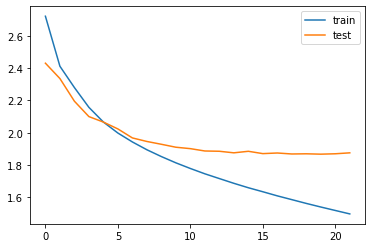

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
# test 모델 
src_index_to_word = src_tokenizer.index_word 
tar_word_to_index = tar_tokenizer.word_index 
tar_index_to_word = tar_tokenizer.index_word 

encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

# token to text
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# token to summary
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [45]:
for i in range(0, 100):
    print("data : ", seq2text(encoder_input_test[i]))
    print("label :", seq2summary(decoder_input_test[i]))
    print("result :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("----------------------------------------------")

data :  sure best regular recommend coffee wanted super beach months taste fast home cost hot excellent 
label : great tasting coffee 
result :  great coffee
----------------------------------------------
data :  coffee old delighted quest baby price great jelly eat 
label : great coffee 
result :  great coffee
----------------------------------------------
data :  start best drinks better gave local amazon really yogurt heated tastier cup worry best taste yum introduced making bottles white unsalted order drinks regular always 
label : the best 
result :  great breakfast
----------------------------------------------
data :  tea bread find keep find spicy bones native bones mild also spicy picked reading cups outer oven ones tell product sick taste ordered 
label : more pancakes tea 
result :  love this tea
----------------------------------------------
data :  product depth dogs including inside weak little wanted quick product taste good well jelly local product fast texture disappo